# レスラー方程式(ランダムなシフト付きsin外力のある状態)

レスラー方程式の外力のある場合に関して，$\sin$ 波に位相のランダムなシフトがある場合を考える．

In [223]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time


CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs


In [224]:
shifts = {}  # 4日ごとの位相シフトを格納する辞書

def phase_shift(t):
    # 4日ごとの区間を識別
    period = int(t / (4*2*np.pi))

    # 新しい位相シフトが必要かどうかをチェック
    if period not in shifts:
        random_shift_hour = np.random.choice(np.arange(-12, 12, 1)) #シフト範囲は -12 から +12
        #shift_value = (random_shift_hour / 24) * 2 * np.pi
        shift_value = (8 / 24) * 2 * np.pi
        shifts[period] += shift_value

    # 現在の位相シフトを返す
    return shifts[period]

In [232]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def coupled_system(t, state, mu, sigma, rho, beta, A):
    X, Y= state
    
    period = int(1.05*t / (4*2*np.pi))
    
    dXdt = Y
    dYdt = mu * (1 - X**2) * Y - X + A * np.sin(1.05*t + period * (-8 / 24) * 2 * np.pi)
    
    return [dXdt, dYdt]

mu = 0.01
sigma = -0.1
rho = 28.0
beta = 8/3
A = 0.1
initial_state = [1.0, 0.0]  # Initial states for [X, Y, x_lorenz, y_lorenz, z_lorenz]

# 時間の設定
t_span = [0, 10000]  # 開始時刻と終了時刻
t_eval = np.linspace(t_span[0], t_span[1], 1000000)  # 評価する時間点

sol = solve_ivp(coupled_system, t_span, initial_state, args=(mu, sigma, rho, beta ,A), t_eval=t_eval)

In [233]:
# 外力P(t)の計算（位相シフト付き）
#P_shifted = A * np.sin(sol.t + np.array([phase_shift(ti) for ti in sol.t]))
#P_shifted = A * np.sin(sol.t)

# DataFrameの作成
data_frame_with_shifted_force = pd.DataFrame({
    'time': sol.t,
    'x': sol.y[0],
    'y': sol.y[1],
    #'P_shifted': P_shifted# 位相シフトされた外力P(t)の列を追加
})


In [234]:
dir_name = f"data"
os.makedirs(dir_name, exist_ok=True)

filename_with_force = f"{dir_name}/VDP_random.csv"

# CSVファイルにデータを保存
data_frame_with_shifted_force.to_csv(filename_with_force, index=False)

# CSVファイルを読み込む
data_loaded_with_force = pd.read_csv(filename_with_force)

# CSVから値を抽出してNumpy配列に格納
X = data_loaded_with_force[['x', 'y']].values


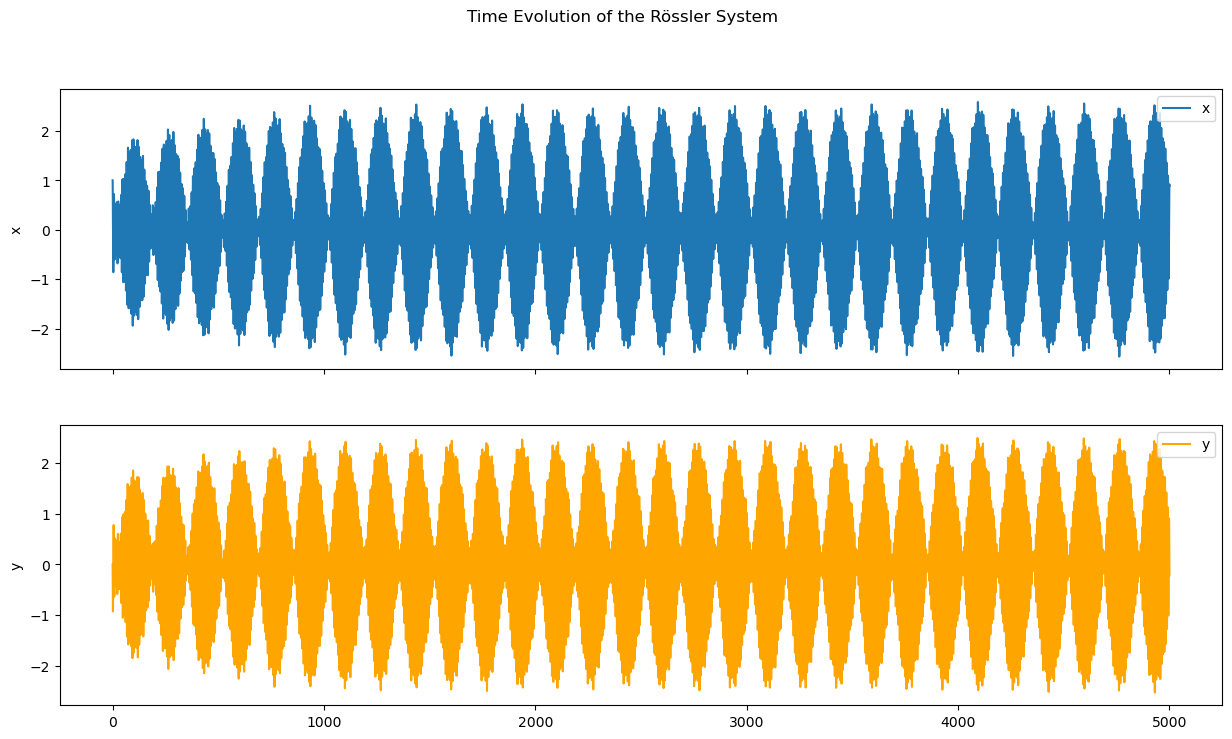

In [235]:
sample = 0
plot_length = 500000

# 時間ごとのx, y, zそれぞれのグラフ
fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
axs[0].plot(data_loaded_with_force['time'][sample: sample+plot_length], data_loaded_with_force['x'][sample: sample+plot_length], label='x')
axs[0].set_ylabel('x')
axs[0].legend(loc='upper right')

axs[1].plot(data_loaded_with_force['time'][sample: sample+plot_length], data_loaded_with_force['y'][sample: sample+plot_length], label='y', color='orange')
axs[1].set_ylabel('y')
axs[1].legend(loc='upper right')

# Plot P_shifted vs. time
#axs[2].plot(data_loaded_with_force['time'][sample: sample+plot_length], data_loaded_with_force['P_shifted'][sample: sample+plot_length], label='P_shifted', color='green')
#axs[2].set_ylabel('P_shifted')
#axs[2].legend(loc='upper right')

plt.suptitle('Time Evolution of the Rössler System')
plt.show()

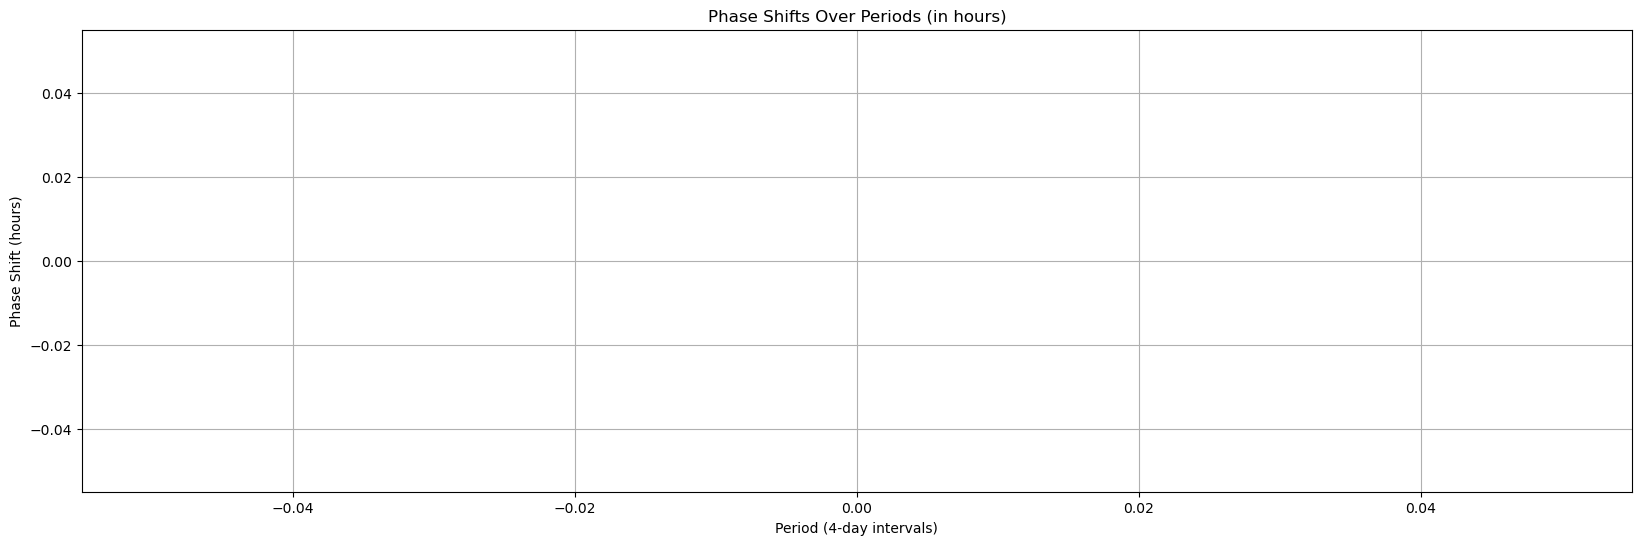

In [236]:
import numpy as np
import matplotlib.pyplot as plt

# shifts 辞書からキーと値を取得し、ラジアンから時間（時）に変換
periods = list(shifts.keys())
phase_shifts = [shift / (2 * np.pi) * 24 for shift in shifts.values()]

# グラフの作成
plt.figure(figsize=(20, 6))
plt.plot(periods, phase_shifts, marker='o')
plt.title('Phase Shifts Over Periods (in hours)')
plt.xlabel('Period (4-day intervals)')
plt.ylabel('Phase Shift (hours)')
plt.grid(True)
plt.show()
